In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import json
import math
import codecs
from curl_cffi import requests as curlrq
import time
import asyncio

url_olx = "https://www.olx.com.br/imoveis/aluguel/estado-pe/grande-recife/recife?pe=1000&ret=1020&ret=1060&ret=1040&sd=3747&sd=3778&sd=3766&sd=3764&sd=3762"
url_wq = "https://www.webquarto.com.br/busca/quartos/recife-pe/Cordeiro%7CV%C3%A1rzea%7CTorre%7CTorr%C3%B5es%7CMadalena%7CIputinga?price_range%5B%5D=0,1000&has_photo=0&smokers_allowed=0&children_allowed=0&pets_allowed=0&drinks_allowed=0&visitors_allowed=0&couples_allowed=0"
url_mgf = "https://www.mgfimoveis.com.br/aluguel/quarto/pe-recife-cidade-universitaria?pricemax=1000"


def makeSoup(url):
    content = curlrq.get(url, impersonate="chrome")
    soup = BeautifulSoup(content.text, "lxml")
    return soup

# Retorna a quantidade de páginas de resultados da busca
def findPagePropsOLX(soup):
    data_str = soup.find("script", {"id": "__NEXT_DATA__"}).get_text()
    props = json.loads(data_str)['props']['pageProps']
    return props
    
def searchOLX():
    soup = makeSoup(url_olx)
    page_props = findPagePropsOLX(soup)
    pages_count = math.ceil(page_props['totalOfAds'] / page_props['pageSize'])
    
    ads = []
    
    for i in range(1, pages_count + 1):
        data = {}
        
        # Evita a repetição do scrape na página inicial
        if i == 1:
            data = page_props['ads']
        else:
            page_url = f'{url_olx}&o={i}'
            soup = makeSoup(page_url)
            page_props = findPagePropsOLX(soup)
            data = page_props['ads']

        for d in data:
            if d.get("subject") is not None:
                ad = {
                    'url': d['url'], 
                    'title': d['subject'],
                    'thumbnail': d['thumbnail'],
                    'price': d['price'],
                    'address': d['location'],
                    'property_type': d['category'],
                }
                ads.append(ad)
        print(f"\nOLX Page {i} scrape done\n")
        
    return ads


# WQ multi-pages test url
# testing-only, keep commented out otherwise
# url_wq = "https://www.webquarto.com.br/busca/quartos/recife-pe?page=1&price_range[]=0,15000&has_photo=0&smokers_allowed=0&children_allowed=0&pets_allowed=0&drinks_allowed=0&visitors_allowed=0&couples_allowed=0"


def findDataWQ(raw):
    # target text between 'window.search' and 'window.search.city_name'
    for line in raw:
        content = line.get_text().strip()
        begin = "window.search = {"
        end = "window.search.city_name"
        if content.find(begin) > -1:
            end_idx = content.find(end)
            data_str = content[len(begin) - 1 : end_idx].strip()[:-1]
            rest_str = content[end_idx:]
            return data_str, rest_str
    return ""

def findPaginationWQ(src):
    arr = src.split(" = ")
    s = arr[3]
    end = s.find("window")
    s = s[:end - 4]
    return json.loads(s)

# Remove caracteres com encoding irrelevante
def sanitizeWQ(s):
    import ast, re, html
    
    # Remove caracteres unicode irrelevantes (emojis, etc.)
    #r = codecs.charmap_encode(re.sub(r'\\/', '/', s), 'ignore')[0].decode('unicode_escape')
    # r = codecs.charmap_encode(s, 'ignore')[0]#.decode('unicode_escape')
    r = re.sub(r'\\/', '/', s)
    charmap_tuple = codecs.charmap_encode(r, 'ignore')
    u_escaped = charmap_tuple[0].decode('unicode_escape', 'replace')
    
    # Remove surrogate pairs (html emojis (e.g.: '\ud83d\udc4', ' &#55356;&#57117;' ) )
    emojiless_str = re.sub(r'[\uD800-\uDFFF]', '', u_escaped)
    # r = re.sub(r'\\u[0-9a-fA-F]{4}', '', r)
    emojiless_str = re.sub(r'\\u[0-9a-fA-F]{4}', '', emojiless_str)
    # bullet point removal
    # emojiless_str = re.sub(r'&\#[a-zA-Z0-9]{1,5}', '', emojiless_str)
    result = emojiless_str
    result = re.sub(r"[\n\r]", r" ", result)
    
    """ undef_chars = result.strip().split()
    for w in undef_chars:
        print(w) """
    # print(f'length: {len(undef_chars)}')
    return result

def adsDataToJsonWQ(data_str):
        ads = []
        # set loads 'strict' arg to False to allow unescaped characters
        data = json.loads(data_str,strict=False)['ads']
        for d in data:
            # Compare and normalize both data shapes
            ad = {
                'url': d['url'], 
                'title': f"{d['title']}. {d['description']}. {d['about_roommate']}",
                'thumbnail': d['main_photo'],
                'price': d['rent_price'],
                'address': f"{d['address']}, {d['location']}",
                'property_type': f"{d['property_type']}. {d['room_type']}",
            }
            ads.append(ad)
        return ads


def searchWQ():
    soup = makeSoup(url_wq)
    raw_scripts = soup.find_all("script")
    ads = []
    
    data_str, pagination = findDataWQ(raw_scripts)
    pagination = findPaginationWQ(pagination)
    data_str = sanitizeWQ(data_str)
    ads.append(adsDataToJsonWQ(data_str))
    
    for i in range(pagination['last_page'] - 1):
        page_url = f"https://www.webquarto.com.br/busca/quartos/recife-pe?page={i + 1}&price_range[]=0,15000&has_photo=0&smokers_allowed=0&children_allowed=0&pets_allowed=0&drinks_allowed=0&visitors_allowed=0&couples_allowed=0"
        makeSoup(page_url)
        raw_scripts = soup.find_all("script")
        data_str, _ = findDataWQ(raw_scripts)
        data_str = sanitizeWQ(data_str)
        ads.append(adsDataToJsonWQ(data_str))    
    
    # Dados dos anúncios em flat list
    ads = [item for sublist in ads for item in sublist]
    return ads

def printAdsSeries(data_arr: list, src: str):
    serieses = []
    
    print(f"Anúncios de Moradia encontrados na {src}:")
    for data in data_arr:
        s = pd.Series(data)
        serieses.append(s)
        # print(f"\n{s}\n")
    
    df = {}
    df = pd.DataFrame(serieses)
    
    return df
    # print(df)
    # for i, data in enumerate(data_arr):    
    
    # print(data_arr[0])
    # df = pd.DataFrame({some_series: pd.Series.keys some_series.title}, index = some_series.index)
    # print(df)

def scrapeAndPrint():
    running = True
    while running:
        return printAdsSeries(searchWQ(), "WebQuartos")
        # printAdsSeries(searchOLX(), "OLX")
        curtime = time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime()) # date.fromtimestamp(t)
        print(f"Scraping finished at {curtime}")
        break
        # await asyncio.sleep(60)

dframe = scrapeAndPrint()

# asyncio.run(scrapeAndPrint())
# scrapeAndPrint()

Anúncios de Moradia encontrados na WebQuartos:
                                                 url  \
0  https://www.webquarto.com.br/quarto/88791/casa...   
1  https://www.webquarto.com.br/quarto/91440/kitn...   
2    https://www.webquarto.com.br/quarto/98518/kinet   
3  https://www.webquarto.com.br/quarto/97678/quar...   
4  https://www.webquarto.com.br/quarto/59267/quar...   
5  https://www.webquarto.com.br/quarto/91795/meu-...   
6  https://www.webquarto.com.br/quarto/98627/quar...   
7  https://www.webquarto.com.br/quarto/76686/alug...   
8  https://www.webquarto.com.br/quarto/98124/quar...   

                                               title  \
0  casa de família!. casa de família que preso se...   
1  Kitnet Mobiliado. Alugo KITNET mobiliado.     ...   
2  kinet. mobiliado com câmara em tudo espaço ext...   
3  Quarto individual em apê na Av. Caxangá. wi-fi...   
4  Quarto para moças. Boa tarde! O apartamento no...   
5  Meu Cantinho.. Condomínio em ótima localização...   


Plotting the data table

In [ ]:
import matplotlib.pyplot as plt

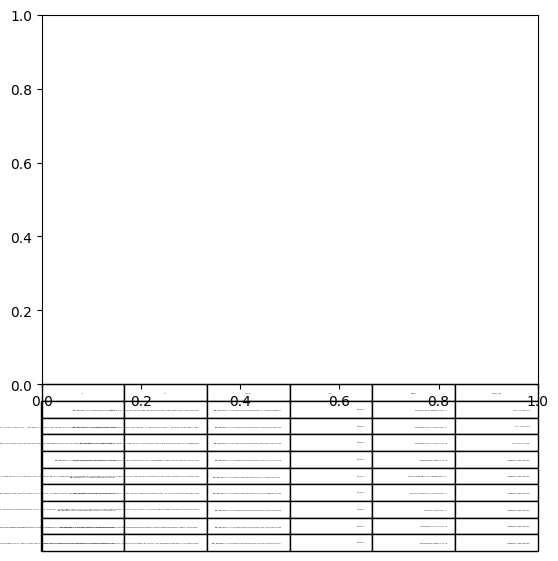

In [24]:
""" import pandas as pd

df = pd.DataFrame({'A': [1, 2], 'B': [3, 4]})

fix, ax = plt.subplots()

ax.axis('off')
(0.0, 1.0, 0.0, 1.0)

table = pd.plotting.table(ax, df, loc='center',
                          cellLoc='center', colWidths=list([.2, .2]))
plt.savefig(fname='figure')

 """
# print(dframe.columns)
fix, ax = plt.subplots()
# ax.axis('off')
table = pd.plotting.table(ax, dframe)
plt.savefig('fig')

In [48]:
# import pandas as pd
# def fizz(x):
#     return 'test'
df = pd.DataFrame({'foo': [0,0], 'bar': [1,1]})
# df = pd.DataFrame({"foo": ['R$ 1.000', 'R$ 1.000,00', 'R$ 100'], "bar": [4,5,6]})
df.apply(lambda x: [1, 2], axis=1, result_type='expand')
# df.apply(lambda x: [1,2], axis=1, result_type='broadcast')

df

,foo,bar
0,0,1
1,0,1


In [59]:
# import pandas as pd
# def fizz(x):
#     return 'test'
df = pd.DataFrame({'foo': [0,0], 'bar': [1,1]})
# df = pd.DataFrame({"foo": ['R$ 1.000', 'R$ 1.000,00', 'R$ 100'], "bar": [4,5,6]})
df.apply(lambda x: [1, 2], axis=1, result_type='broadcast')
# df.apply(lambda x: [1,2], axis=1, result_type='broadcast')


print(df.foo)

0    0
1    0
Name: foo, dtype: int64


# PoC - Browser debugger data retrieval (untested)

   ```python
   from selenium import webdriver
   from selenium.webdriver.common.by import By
   from selenium.webdriver.chrome.service import Service
   from selenium.webdriver.chrome.options import Options

   options = Options()
   options.headless = True  # Run in headless mode (without opening a browser window)
   service = Service("path/to/chromedriver")
   driver = webdriver.Chrome(service=service, options=options)

   driver.get("https://example.com")
   # Access debugger data or network logs
   network_log = driver.get_log("browser")
   for entry in network_log:
       print(entry)

   driver.quit()
   ```

### Using Browser Console Logs
```python
from selenium import webdriver

driver = webdriver.Chrome()
driver.get("https://example.com")
console_logs = driver.get_log("browser")
for log in console_logs:
    print(log)

driver.quit()
```

### WebQuarto Ad Location Retrieval

In [134]:
from curl_cffi import requests as crq
from bs4 import BeautifulSoup
import re
import json

url = 'https://www.webquarto.com.br/busca/quartos/recife-pe?page=2&price_range[]=0,15000&has_photo=0&smokers_allowed=0&children_allowed=0&pets_allowed=0&drinks_allowed=0&visitors_allowed=0&couples_allowed=0#'
content = crq.get(url).text
soup = BeautifulSoup(content) # missing parser
scriptTags = soup('script')

# fix enconding before str conversion using BS props/methods

# /fix

tagStr = soup.find('script', string=re.compile(r'window.search*')).get_text(strip=True)
splitTagStr = tagStr.splitlines()

# cleanup

dataStr = splitTagStr[0].removeprefix('window.search = ').removesuffix(';')
# endIdx = dataStr.rfind(';')
# dataStr = dataStr[:endIdx]
dataJson = json.loads(dataStr)
# print(dataJson['ads'][0]['lat'])
urls = [data['url'] for data in dataJson['ads']]

adsCoords = [ { 'lat': data['lat'], 'lng': data['lng']} for data in dataJson['ads']]

# def getCoordsFromAd(url: str):
#     # makeSoup(url)
#     soup = BeautifulSoup(crq.get(url).text) # missing parser for BS (try html5lib?)
    
#     admap = soup('ad-map')[0]
#     return { 'lat': admap[':lat'], 'lng': admap[':lng'] }

# # find ad-map tags with :lat :lng attrs
# adsCoords = []
# for url in urls:
#     adsCoords.append(getCoordsFromAd(url))

adsCoords

[{'lat': '-8.1167442', 'lng': '-34.9423072'},
 {'lat': '-8.1145399', 'lng': '-34.8936611'},
 {'lat': '-8.0739659406436', 'lng': '-34.93332364711'},
 {'lat': '-8.1274663', 'lng': '-34.9046739'},
 {'lat': '-8.0281219', 'lng': '-34.9159133'},
 {'lat': '-8.1159825', 'lng': '-34.8940974'},
 {'lat': '-8.0499881257228', 'lng': '-34.921177985902'},
 {'lat': '-8.0607371', 'lng': '-34.9064649'},
 {'lat': '-8.1378501', 'lng': '-34.9032331'},
 {'lat': '-8.1343854647686', 'lng': '-34.901212491982'},
 {'lat': '-8.0344179', 'lng': '-34.8865966'},
 {'lat': '-8.0972854', 'lng': '-34.8848234'},
 {'lat': '-8.1380711', 'lng': '-34.9134289'},
 {'lat': '-8.0633595411608', 'lng': '-34.929215120633'},
 {'lat': '-8.0503126972526', 'lng': '-34.898536656033'},
 {'lat': '-8.0383886', 'lng': '-34.8889842'}]

### OLX Ad CEP retrieval

In [ ]:
url = 'https://pe.olx.com.br/grande-recife/imoveis/alugo-cs-popular-de-vila-lateral-com-1-quarto-1326921656?lis=listing_1002'

soup = BeautifulSoup(crq.get(url).text)
# soup('')

<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]--><!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]--><!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]--><!--[if gt IE 8]><!--><html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Attention Required! | Cloudflare</title>
<meta charset="utf-8"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
<meta content="noindex, nofollow" name="robots"/>
<meta content="width=device-width,initial-scale=1" name="viewport"/>
<link href="/cdn-cgi/styles/cf.errors.css" id="cf_styles-css" rel="stylesheet"/>
<!--[if lt IE 9]><link rel="stylesheet" id='cf_styles-ie-css' href="/cdn-cgi/styles/cf.errors.ie.css" /><![endif]-->
<style>body{margin:0;padding:0}</style>
<!--[if gte IE 10]><!-->
<script>
  if (!navigator.cookieEnabled) {
    window.addEventListener('DOMContentLoaded', function () {